In [3]:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import sys
sys.path.append("../../../main/")
import scglue

In [4]:
import os 
os.chdir("../../../DATA/H3k4me3/")

In [5]:
rna = ad.read_h5ad("rna.h5ad")
atac = ad.read_h5ad("peakMat.h5ad")

In [6]:
scglue.data.get_gene_annotation(
    rna, gtf="../Mouse_embryo/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)

In [7]:
rna = rna[:,~rna.var["chrom"].isna()]

In [8]:
rna.layers["counts"] = rna.X
sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3", layer="counts")

In [9]:
split = atac.var_names.str.split(r"[:-]")
atac.var["chrom"] = split.map(lambda x: x[0])
atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# atac.var.head()

In [10]:
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac)
# guidance

window_graph: 100%|██████████| 19588/19588 [00:02<00:00, 7192.87it/s]


In [11]:
atac.obs_names = [i.split("-")[0] for i in list(atac.obs_names)]
comm_cells = list(set(atac.obs_names) & set(rna.obs_names))
atac = atac[comm_cells]
rna = rna[comm_cells]
atac.obsm["spatial"] = rna.obsm["spatial"]

In [12]:
scglue.data.lsi(atac, n_components=100, n_iter=15)

In [13]:
from itertools import chain

In [14]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.query("highly_variable").index
)).copy()

In [15]:
rna.X = rna.layers["counts"]
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

In [16]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
)
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,use_rep="X_lsi",
)

In [16]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    model=scglue.models.SCGLUEModel,
    fit_kws={"directory": "glue"},
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 28016
[INFO] SCGLUEModel: Setting `max_epochs` = 179
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.465, 'g_kl': 0.005, 'g_elbo': 0.47, 'x_rna_nll': 0.23, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.234, 'x_atac_nll': 0.071, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.072, 'dsc_loss': 0.692, 'vae_loss': 0.324, 'gen_loss': 0.29}, val={'g_nll': 0.463, 'g_kl': 0.005, 'g_elbo': 0.468, 'x_rna_nll': 0.23, 'x_rna_kl': 0.004, 'x_rna_elbo': 0.234, 'x_atac_nll': 0.072, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.073, 'dsc_lo

2024-12-17 21:08:09,137 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "40"...
[INFO] EarlyStopping: Restoring checkpoint "40"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 12)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 28016
[INFO] SCGLUEModel: Setting `align_burnin` = 30
[INFO] SCGLUEModel: Setting `max_epochs` = 179
[INFO] SCGLUEModel: Setting `patience` = 15
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 8
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.432, 'g

2024-12-17 21:14:25,401 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "55"...
[INFO] EarlyStopping: Restoring checkpoint "55"...


In [17]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

In [18]:
combined = ad.concat([rna, atac], label="omics")

In [19]:
sc.pp.neighbors(combined, use_rep="X_glue")
sc.tl.umap(combined)

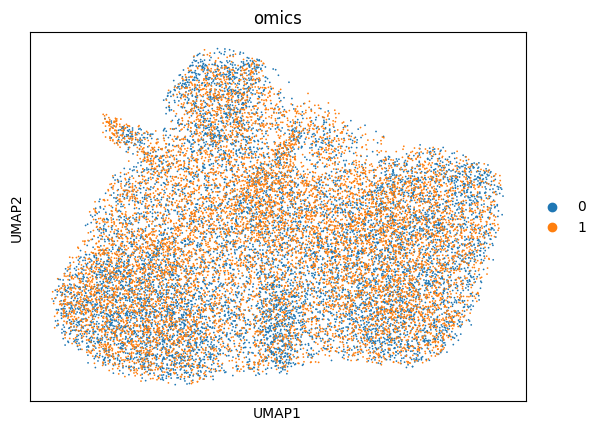

In [20]:
sc.pl.umap(combined, color="omics")

In [21]:
import pandas as pd
def res_search_fixed_clus(adata, fixed_clus_count, increment=0.05):
    closest_count = np.inf  
    closest_res = None  
    
    for res in sorted(list(np.arange(0.1, 2, increment)), reverse=True):
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
        current_diff = abs(count_unique_leiden - fixed_clus_count)
        if current_diff < closest_count:
            closest_count = current_diff
            closest_res = res
        if count_unique_leiden == fixed_clus_count:
            break

    return closest_res

In [22]:
res =  res_search_fixed_clus(combined, fixed_clus_count=17)

In [23]:
sc.tl.leiden(adata=combined, resolution=res)

In [24]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

In [28]:
# sc.pl.spatial(t_rna, color="leiden",spot_size=35)
# sc.pl.spatial(t_atac, color="leiden",spot_size=35)

In [26]:
# cluster = combined.obs['leiden']
# cluster.to_csv("rep1/GLUE_cluster.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/GLUE_umap.csv")
# embed = pd.DataFrame(combined.obsm["X_glue"])
# embed.to_csv("rep1/GLUE_embed.csv")